In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import warp_polar, rotate
import os
import pandas as pd
import math
# np.set_printoptions(threshold=sys.maxsize)

print(cv2.__version__)

4.5.1


In [3]:
file_names = os.listdir("images")
file_names = ["images\{}".format(name) for name in file_names]

cb_images =list()
cropped_images= list()
original_images = list()
for file_name in file_names:
    image = cv2.imread(file_name)
    cropped_image= image[40:550,130:650]
    cropped_image[0:30,0:30]= 0
    cropped_images.append(cropped_image.copy())
    blurred_image = cv2.GaussianBlur(cropped_image,(13,13),0)
    cb_images.append(blurred_image)
    
 

In [4]:

def find_best_circle(img):
    circles = cv2.HoughCircles(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.HOUGH_GRADIENT,2.0,minDist=190,
                                    param1=104,param2=400,minRadius=220,maxRadius=250)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        return circles

def compute_centroid(img,x_center, y_center,area):
    x_accumulator = y_accumulator=0
    counter = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j]>= 60:
                x_accumulator += i 
                y_accumulator += j 
    x = np.rint(x_accumulator/area)
    y = np.rint(y_accumulator/area)

    return (int(y),int(x))


def compute_rotation_angle(x,y):
    res = np.arctan2(y,x)*180/np.pi
    if y>=0 and x>=0:
        return res+90
    elif y>=0 and x<=0:
        return res+90
    elif y<=0 and x>=0:
        return np.abs(90+res)
    elif y<=0 and x<=0:
        return res+90



center has coordinate (253,243), radius = 232


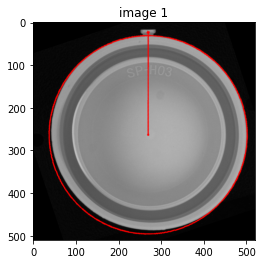

####################################
center has coordinate (251,243), radius = 230


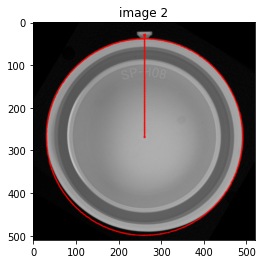

####################################
center has coordinate (247,243), radius = 223


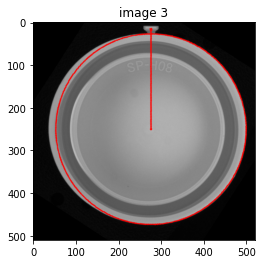

####################################
center has coordinate (251,247), radius = 229


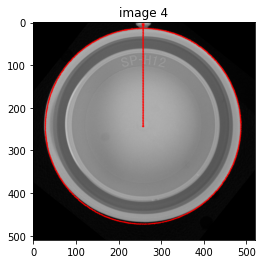

####################################
center has coordinate (255,247), radius = 229


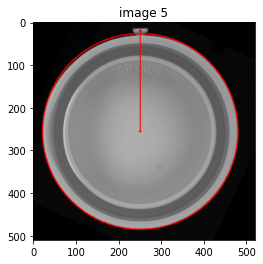

####################################
center has coordinate (255,251), radius = 228


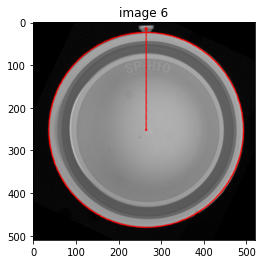

####################################
center has coordinate (259,249), radius = 228


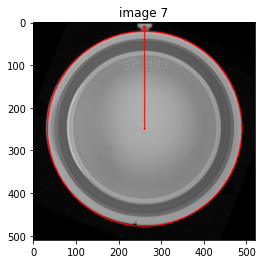

####################################
center has coordinate (249,249), radius = 230


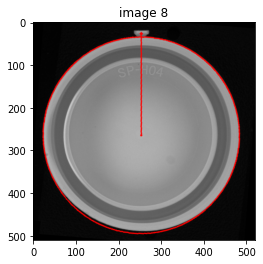

####################################
center has coordinate (247,245), radius = 229


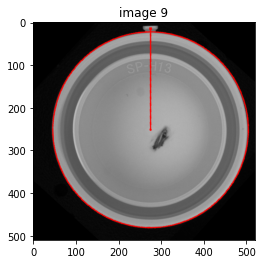

####################################
center has coordinate (253,245), radius = 229


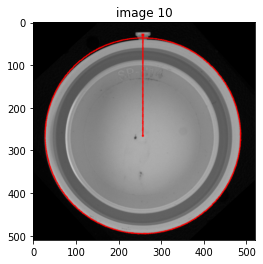

####################################
center has coordinate (247,249), radius = 228


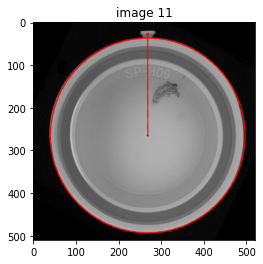

####################################
center has coordinate (247,247), radius = 228


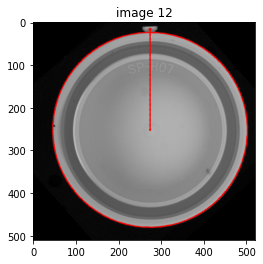

####################################
center has coordinate (255,245), radius = 227


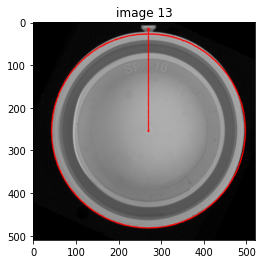

####################################
center has coordinate (259,245), radius = 232


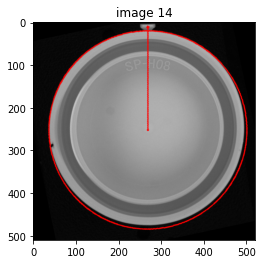

####################################
center has coordinate (255,247), radius = 228


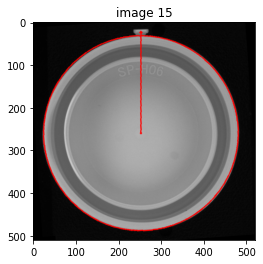

####################################
center has coordinate (253,247), radius = 229


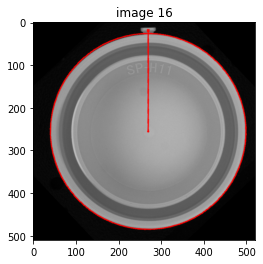

####################################
center has coordinate (253,249), radius = 228


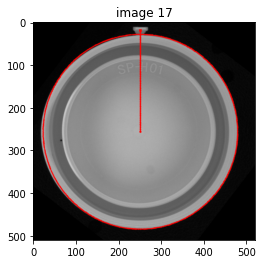

####################################
center has coordinate (249,245), radius = 226


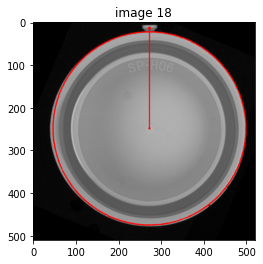

####################################
center has coordinate (249,245), radius = 227


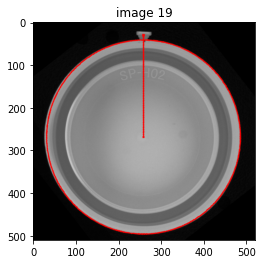

####################################
center has coordinate (253,249), radius = 229


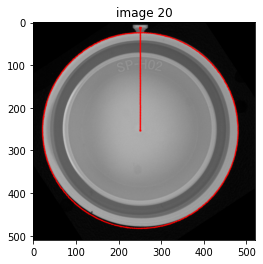

####################################
center has coordinate (249,247), radius = 230


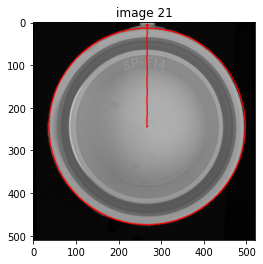

####################################
center has coordinate (255,243), radius = 229


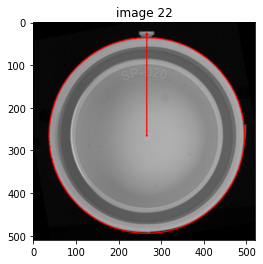

####################################
center has coordinate (257,249), radius = 227


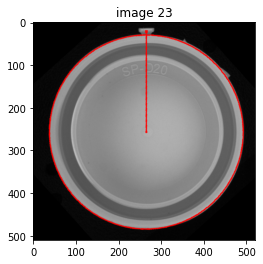

####################################
center has coordinate (251,249), radius = 228


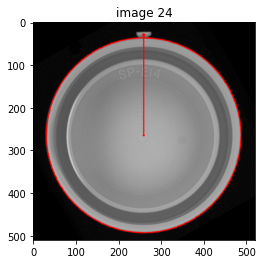

####################################
center has coordinate (261,247), radius = 228


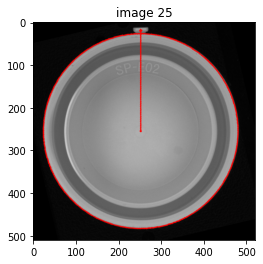

####################################
center has coordinate (251,249), radius = 227


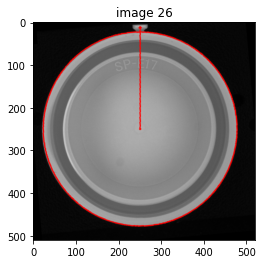

####################################
center has coordinate (253,247), radius = 226


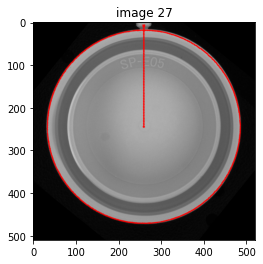

####################################
center has coordinate (253,249), radius = 228


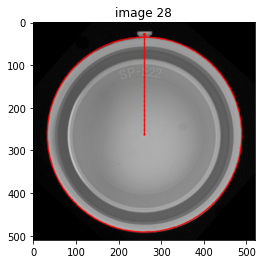

####################################


In [24]:
tabs = list()
rotated_images= list()
centers = list()
for i in range(0,len(cb_images)):
    focus = cb_images[i].copy()
    # original = cv2.cvtColor(cropped_images[i],cv2.COLOR_BGR2RGB).copy()
    original = cropped_images[i].copy()
    circles = find_best_circle(focus)
    # plt.figure(figsize=(5,5))

    tab = cv2.cvtColor(focus,cv2.COLOR_BGR2GRAY).copy()
    
    for (x,y,r) in  circles:
        x_center = x
        y_center = y
        centers.append((x,y,r))
        print("center has coordinate ({},{}), radius = {}".format(x,y,r))
        highlighted = cv2.circle(focus,(x,y),r,(0,255,255),1)
        original = cv2.circle(original,(x,y),r,(255,0,0),2)
        original = cv2.circle(original,(x,y),1,(255,0,0),2) # adding the centre of the circle
        tab = cv2.circle(tab,(x,y),r,(0,0,0),-1)


    opened = cv2.blur(tab,(5,5))
    
    opened = cv2.threshold(tab,70,255, type = cv2.THRESH_BINARY,)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened= cv2.morphologyEx(opened, cv2.MORPH_OPEN,kernel,-1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    opened = cv2.morphologyEx(opened,cv2.MORPH_ERODE,kernel,-1)
    
    
    labels = measure.label(opened)
    
    # print("labels ={}".format(np.unique(labels)))# never decomment this 
    # print("There are {} blob/s".format(len(np.unique(labels))))

    properties =['area','perimeter','bbox','bbox_area',
                'convex_area',
            'major_axis_length', 'minor_axis_length',
            'eccentricity','label'
            ]
    df = pd.DataFrame(regionprops_table(labels, properties = properties))
    df["compactness"]= df["perimeter"]**2/df["area"]
    df["rectangularity"] = df["area"]/df["bbox_area"]
        
    # if len(np.unique(labels))>=2:
    df= df[df["area"]>=20]
    df= df[df["area"]<=500]
    df=df.sort_values(["compactness","area",'rectangularity'], ascending=[True,False,True])

    best =df.iloc[0]['label']
    area = df.iloc[0]["area"]
    
    
    labels[labels==best]=255

    (x_tab,y_tab) = compute_centroid(labels,x,y,area)
    
    angle = compute_rotation_angle(x_tab-x_center,y_tab-y_center)
    

    # print("we need to rotate by {} degree".format(angle))    
    # original =cv2.circle(original,(x_tab,y_tab),1,(0,0,0),10) # adding the barycenter of the centroid
    
    original = cv2.circle(original,(x_tab,y_tab),2,(255,0,0),3)
    original = cv2.line(original,(x_tab,y_tab),(x_center,y_center),(255,0,0),2)

    rotated_image= rotate(original,angle)

    # print("shape= {}".format(rotated_image.shape))

    # print("type= {}".format(type(rotated_image)))    

    rotated_image = cv2.convertScaleAbs(rotated_image, alpha=(255.0))
    cv2.imwrite("highlighted\highlighted_{}.bmp".format(i), rotated_image)
    # da decommentare per ottenere il salvataggio delle foto con 

    plt.imshow(rotated_image,cmap="gray")
    plt.title("image {}".format(i+1))
    
    # plt.title("degree {}".format(np.round(angle,2)))
    plt.show()
    
    rotated_images.append(rotated_image)

    # cv2.circle(tab,(x, y),1,(255,255,255),10)
    print("####################################")
   

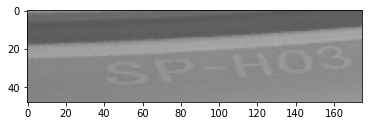

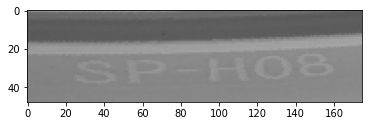

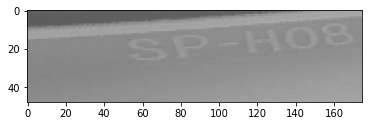

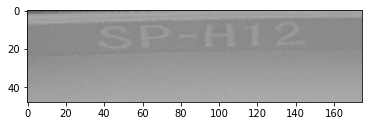

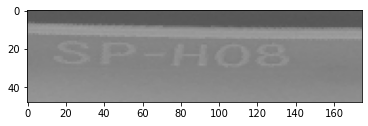

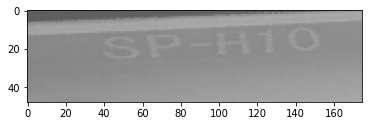

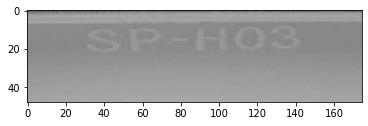

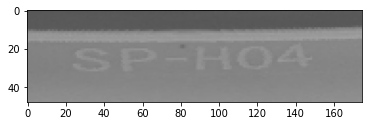

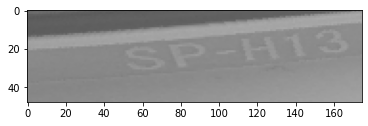

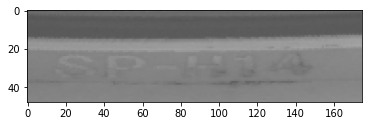

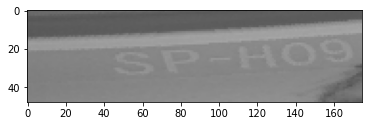

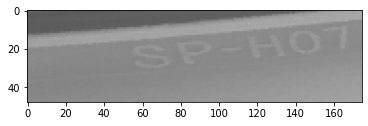

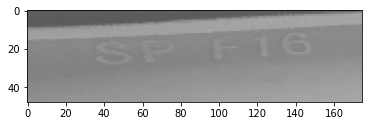

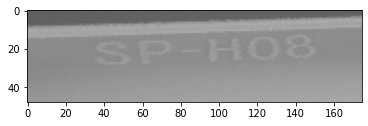

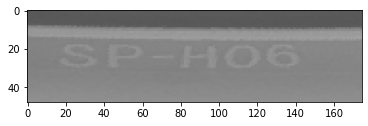

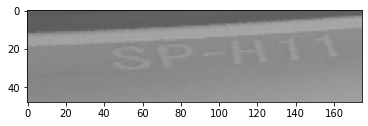

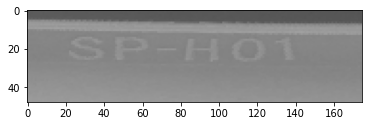

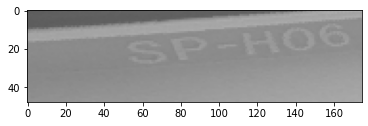

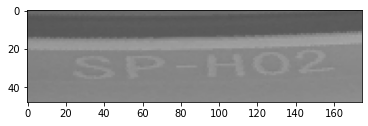

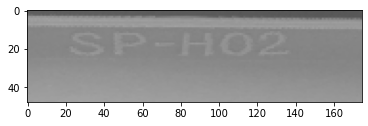

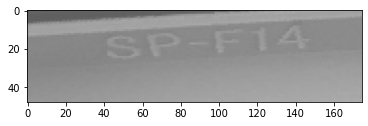

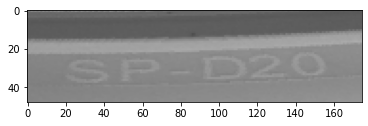

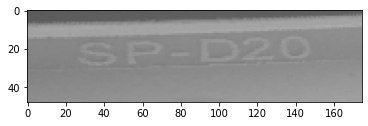

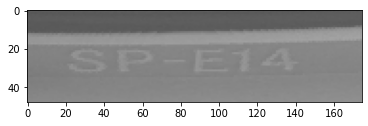

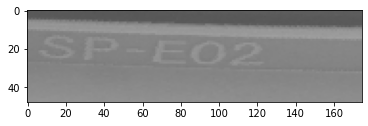

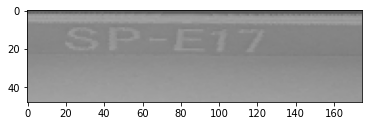

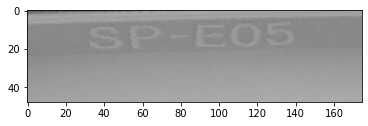

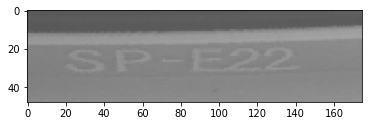

In [6]:
cavity_numbers = list()
for i in range(len(rotated_images)):
    img = rotated_images[i]
    (x,y,r) = centers[i]

    margin = 0.8 # Cut off the outer 10% of the image
    # Do the polar rotation along 1024 angular steps with a radius of radius pixels.
    polar_img = cv2.warpPolar(img, (r, 1024), (x,y), image.shape[1]*margin*0.7, cv2.WARP_POLAR_LINEAR)
    # polar_img = cv2.warpPolar(image, (232, 1024), (243,253), image.shape[1]*margin*0.65, cv2.WARP_POLAR_LINEAR)
    # Rotate it sideways to be more visually pleasing
    polar_img = cv2.rotate(polar_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # plt.imshow(polar_img),plt.show()
    crop = polar_img[130:178,685:860].copy()
    plt.imshow(crop),plt.show()
    # crops.append(crop)    

    cavity_numbers.append(crop)
    # plt.imshow(crop),plt.title("crop #{}".format(i+1)),plt.show()
    # cavity_number = cv2.convertScaleAbs(cavity_number, alpha=(255.0))
    # cv2.imwrite("cavity\Cavity_{}.bmp".format(i),cavity_number) # 




in if  0


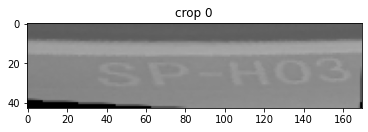

in if  1


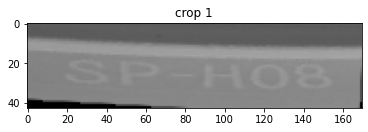

in if  2


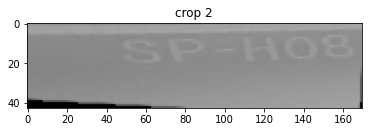

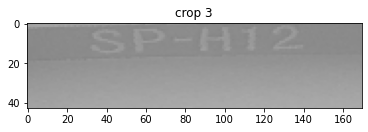

in if  4


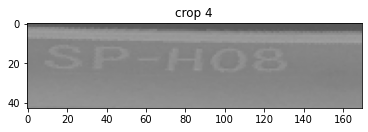

in if  5


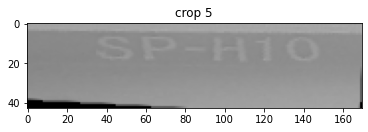

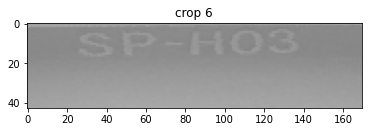

in if  7


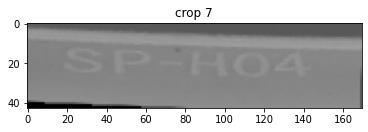

in if  8


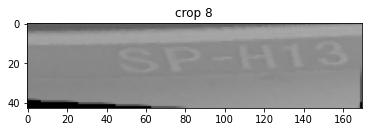

in if  9


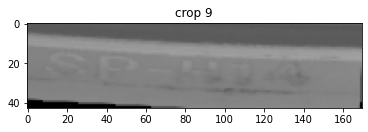

in if  10


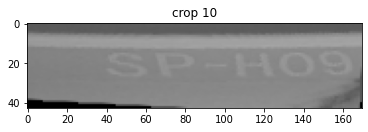

in if  11


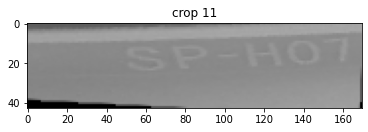

in if  12


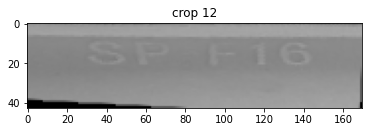

in if  13


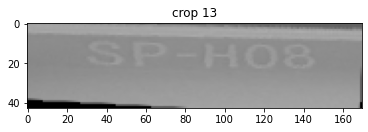

in if  14


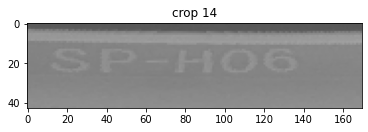

in if  15


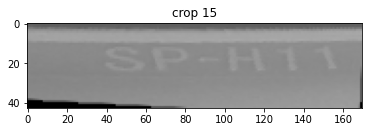

in if  16


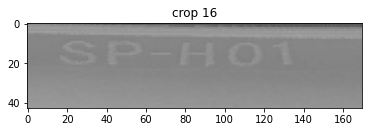

in if  17


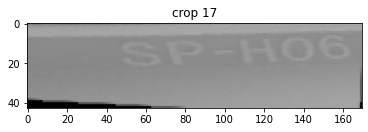

in if  18


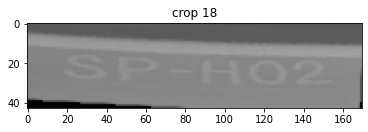

in if  19


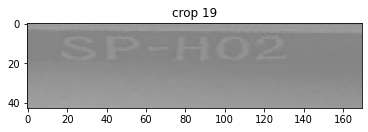

in if  20


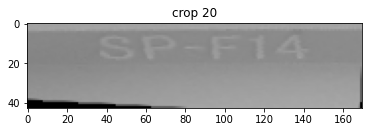

in if  21


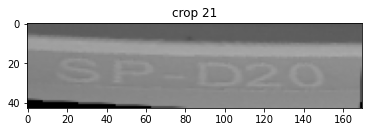

in if  22


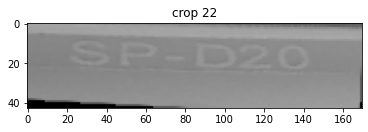

in if  23


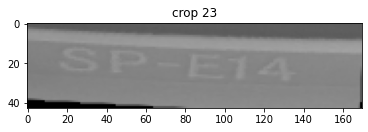

in if  24


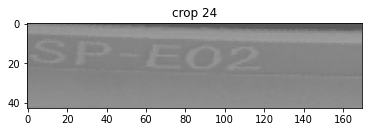

in if  25


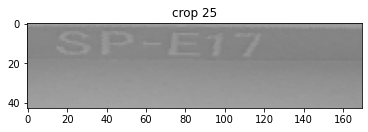

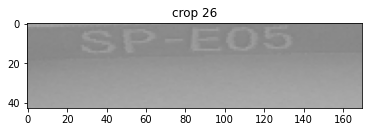

in if  27


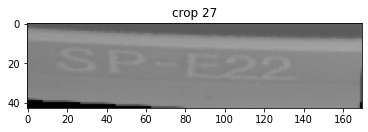

In [20]:
from skimage.transform import hough_line, hough_line_peaks,probabilistic_hough_line
for i in range (len(cavity_numbers)):
    crop = cavity_numbers[i]
    blurred_image = cv2.GaussianBlur(crop,(15,15),0)
    edges = cv2.Canny(blurred_image[0:20,:],threshold1= 20, threshold2=40)
    lines = probabilistic_hough_line(edges, threshold=50, line_length=10,
                                 line_gap=3)

    points = list()
    for l in lines:
        points.append(l[0])
        points.append(l[1])
    
    
    points= sorted(points,key=lambda item: item[1],reverse=False)
    
    # print(points)
    # print(dst)
    if len(points)!=0:
        print("in if ",i)
        maxp = points[len(points)-1]
        minp= points[0]
        # if maxp[1]-minp[1]>=4:
        angle =np.arctan2(maxp[1]-minp[1],maxp[0]-minp[0])
        
        crop= rotate(crop,-angle)

    # plt.imshow(edges),plt.show()

    crop = crop[5:65,5:185]
    plt.imshow(crop),plt.title("crop {}".format(i)),plt.show()
    # print(crop.shape)
    # crops.append(crop)
    if i not in [3,6,26]:
        crop = cv2.convertScaleAbs(crop, alpha=(255.0))

    cv2.imwrite("cavity\Cavity_{}.bmp".format(i),crop) # 
    # print("######################")